In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

from tqdm import tqdm # Profiling 
from tqdm.gui import tqdm as tqdm_gui
import seaborn as sbn
import pickle, sys, importlib


function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [2]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

Compute the total power  of BT prod and Load on St Laurent 


In [3]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

In [4]:
row2read = 8784 # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100
upscale_factor = 10


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, row2read)
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder, row2read)
p_mw_0100 = p_mw_0013*upscale_factor
p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0013), freq='10T')


# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013, 
                'P0018': p_mw_0018,
                'P0100': p_mw_0100}

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index)

# Dataframe Conso BT 
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index)

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

#### Plot Total prod BT and Total Load demand

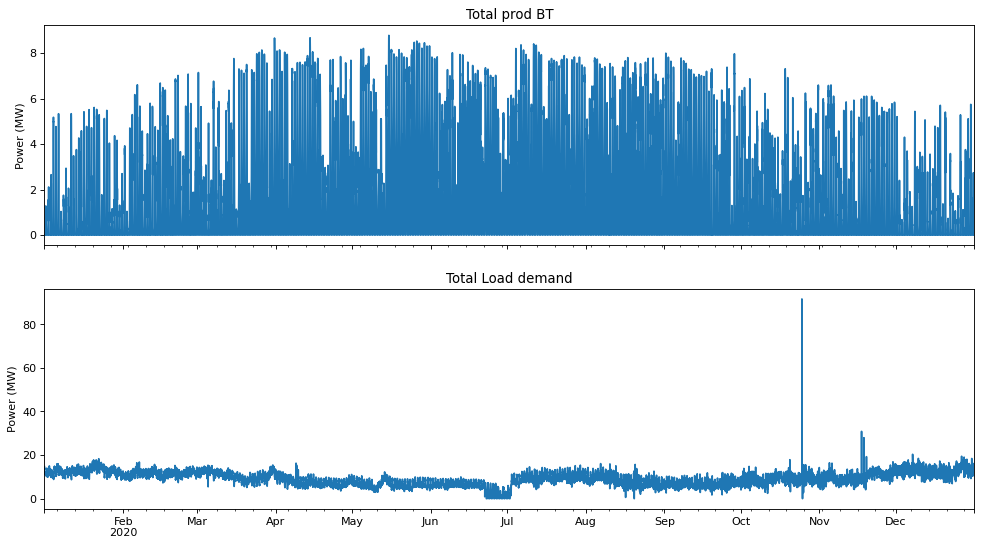

In [5]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total[0].plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total[0].plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

In the previous figure, the pic of demand occurring toward the end of October does not make sense. The disparity is undoubtedly due to a recording error. We will replace the recorded value with the mean of the previous and following periods

In [6]:
max_indx = df_cons_total[0].argmax()  # Get the indice of the period where the pic occurs

# replace the value with the mean of the previous and following periods
df_cons_total[0][max_indx] = (df_cons_total[0][max_indx-1] + df_cons_total[0][max_indx-1])/2

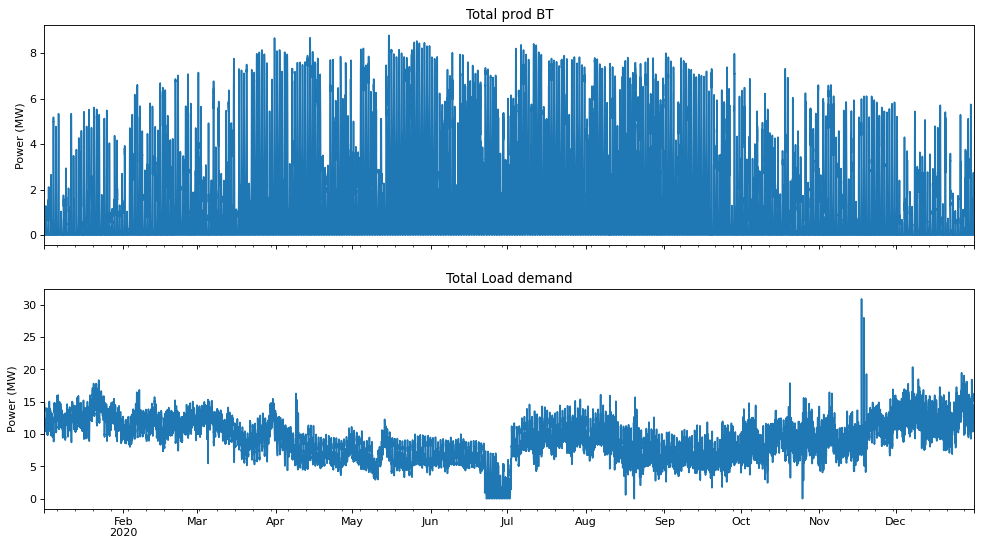

In [7]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total[0].plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total[0].plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Zoom on the end of june of the total demand

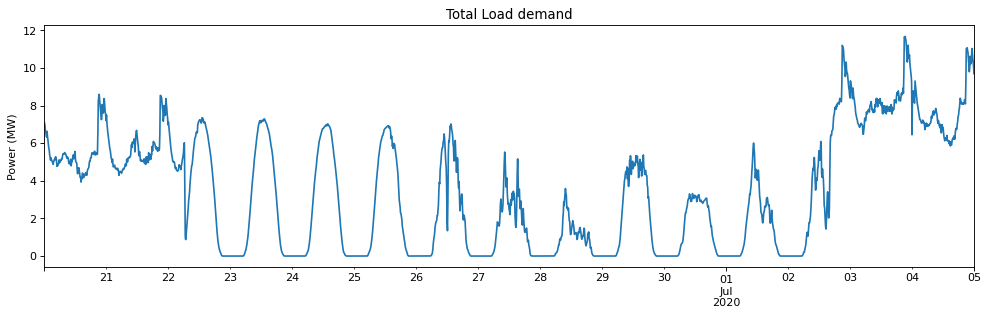

In [8]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

<div class="alert alert block alert-danger ">
    <b>Important:</b> Total load demand follows a PV production cycle like from 2020-06-22 to 2020-07-03 included   
</div>    

#####  Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [9]:
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

#### Check wether the wrong data have been replaced

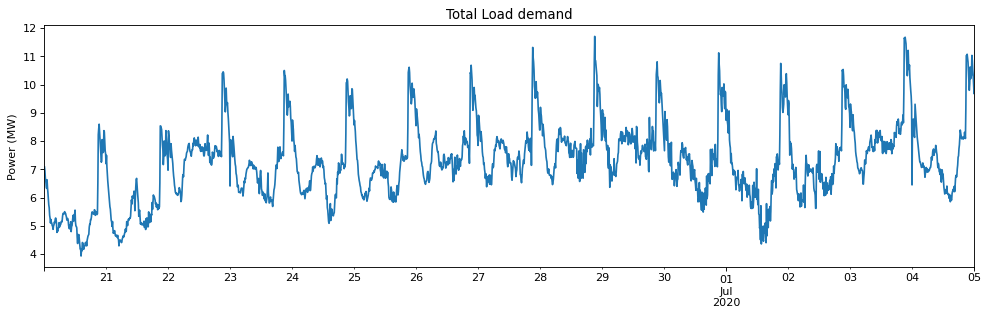

In [10]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Plot Total prod HT 

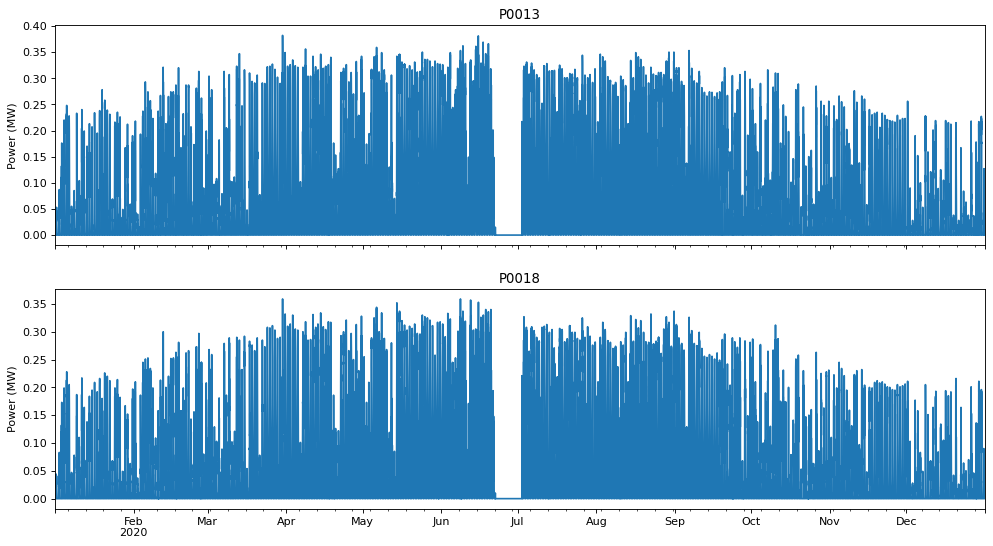

In [11]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');

### Highlight where data is missing

<AxesSubplot:>

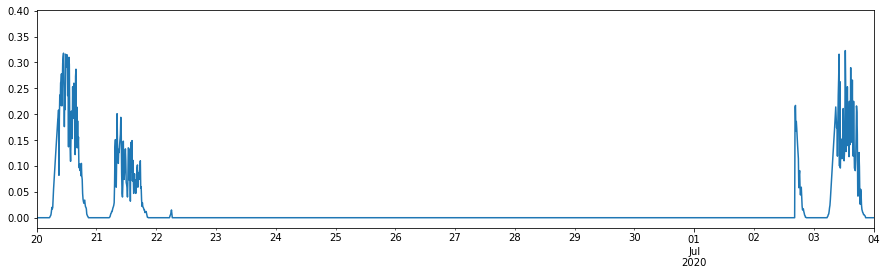

In [12]:
df_prodHT['P0013'].plot(xlim=('06 20 2020', '07 04 2020'), figsize=(15,4))

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b>
11 Days of data are missing (06-22 to 07-03)
</div>

##### Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [13]:
# Extract previous and following days 
previous_days = df_prodHT[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_prodHT[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]

# Put the interpolated data into the dataframe
df_prodHT[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

### Replot data to verify

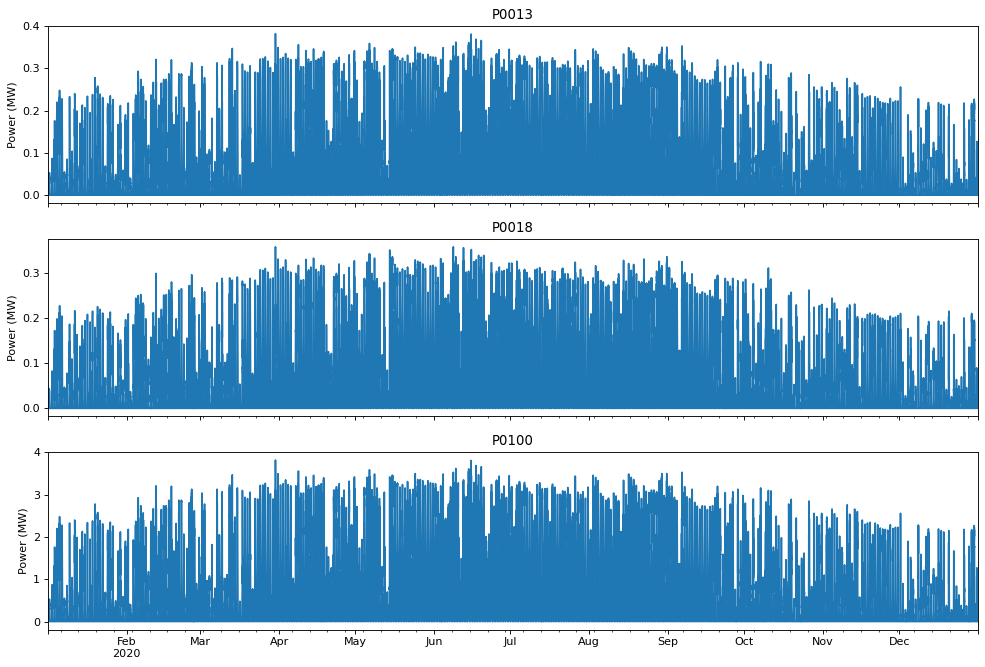

In [14]:
fig, axx = plt.subplots(3, figsize=(15,10),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');
df_prodHT['P0100'].plot(ax=axx[2], title='P0100', ylabel='Power (MW)');

#### Extract activated bus 

In [15]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

#### Load data from simulation made in [Res_Sim_STLaurentDeJourdes](STLaurentDeJourdes.ipynb)

In [16]:
file_loc = 'pickle_files/simulationResults/'

with open(file_loc+"STLaurentDeJourdes.pkl", 'rb') as file:
    STLaurentDeJourdes_dict = pickle.load(file)

In [17]:
list_max_vm_pu = STLaurentDeJourdes_dict['list_max_vm_pu']
list_index_max_vm_pu = STLaurentDeJourdes_dict['list_index_max_vm_pu']

#### Plot the maximum voltage on the network 

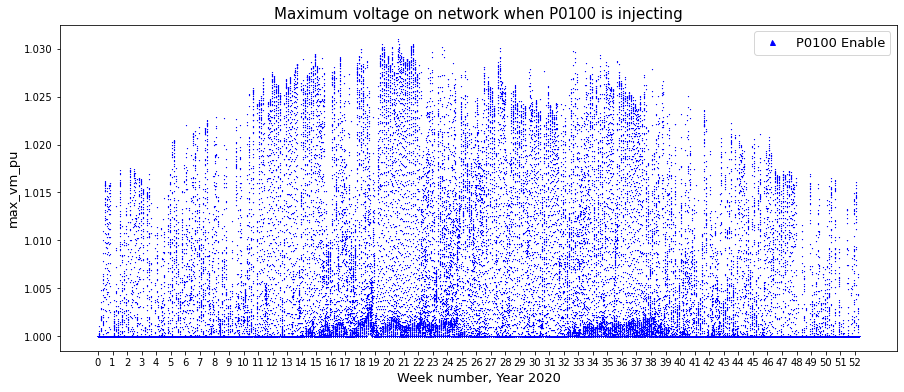

In [18]:
max_vm_pu_df = pd.DataFrame(data=list_max_vm_pu, index=per_index, columns=['max_vm_pu'])
plt.figure(figsize=(15,6))
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df.values,'b^', markersize=0.5, label='P0100 Enable')

nb_per_days = 6*24 # Total number of periods whitin a day
nb_per_week = nb_per_days*7
plt.xticks(range(0,len(max_vm_pu_df), nb_per_week), labels=range(53));
plt.xlabel('Week number, Year 2020',fontsize=13);
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(fontsize=13, markerscale=10)
plt.title("Maximum voltage on network when P0100 is injecting", fontsize=15);

# plt.xlim([0,144*10])

### Find connection between the HV producers and the elements in the network

In [19]:
net_civaux1=pp.from_pickle(f'{network_folder}CIVAUX.p') #  Reload network with new name 

In [20]:
net_civaux1.sgen[net_civaux1.sgen.name.notna()]

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw
21,P0013,51,0.0,0.0,NaN,1.0,True,wye,True,0.39
22,P0018,46,0.0,0.0,NaN,1.0,True,wye,True,0.40
23,P0100,7,0.0,0.0,NaN,1.0,True,wye,True,4.26


In [21]:
hvSgen_bus_number = net_civaux1.sgen[net_civaux1.sgen.name.notna()].bus

#### Hv producenr connected to bus 51

In [22]:
mf.check_bus_connection(net_civaux, [list(hvSgen_bus_number)[0]], attr_list)

----------******            Bus 51 net.bus.name         ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
51   51   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******            Bus 51 net.switch.bus         ******-------
    bus  element et  type  closed name  z_ohm
42   51       49  b  None    True  jdb    0.0 





In [23]:
mf.check_bus_connection(net_civaux, [49], attr_list)

----------******            Bus 49 net.bus.name         ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
49   49   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******            Bus 49 net.switch.bus         ******-------
    bus  element et  type  closed                           name  z_ohm
41   49       50  b  None    True  Cellule Fermée(manuelle) 8263    0.0 





In [24]:
mf.check_bus_connection(net_civaux, [50], attr_list)

----------******            Bus 50 net.bus.name         ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
50   50   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******            Bus 50 net.line.from_bus         ******-------
    name        std_type  from_bus  to_bus  length_km  r_ohm_per_km  \
81  None  Alu150_C33-226        50     307   0.232407         0.206   

    x_ohm_per_km  c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  \
81          0.11        310.0          0.0     0.307  1.0         1  NaN   

    in_service  
81        True   





In [25]:
mf.check_bus_connection(net_civaux, [307], attr_list)

----------******            Bus 307 net.bus.name         ******-------
    name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
307  307   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******            Bus 307 net.line.to_bus         ******-------
    name        std_type  from_bus  to_bus  length_km  r_ohm_per_km  \
81  None  Alu150_C33-226        50     307   0.232407         0.206   
82  None  Alu150_C33-226       309     307   0.137020         0.206   
83  None   Alu95_C33-226       310     307   0.011059         0.320   

    x_ohm_per_km  c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  \
81          0.11        310.0          0.0     0.307  1.0         1  NaN   
82          0.11        310.0          0.0     0.307  1.0         1  NaN   
83          0.12        210.0          0.0     0.241  1.0         1  NaN   

    in_service  
81        True  
82        True  
83        True   





#### Hv producers connected to bus 46

In [26]:
mf.check_bus_connection(net_civaux1, [list(hvSgen_bus_number)[1]], attr_list)

----------******            Bus 46 net.bus.name         ******-------
   name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
46   46   20.6    b  None        True    1.05    0.95        NaN        NaN 





#### Hv producers connected to bus 7

In [27]:
mf.check_bus_connection(net_civaux1, [list(hvSgen_bus_number)[2]], attr_list)

----------******            Bus 7 net.bus.name         ******-------
  name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
7    7   20.6    b  None        True    1.05    0.95        NaN        NaN 

----------******            Bus 7 net.switch.bus         ******-------
     bus  element et  type  closed name  z_ohm
268    7      519  b  None    True  jdb    0.0 





In [28]:
mf.check_bus_connection(net_civaux1, [519], attr_list)

----------******            Bus 519 net.bus.name         ******-------
    name  vn_kv type  zone  in_service  max_vm  min_vm  max_vw_pu  min_vm_pu
519  519   20.6    b  None        True     NaN     NaN       1.05       0.95 





### Disconnect Producer P0100 from the network

#### Disable switch connected to bus 7 which is connected to the producer P0100


In [29]:
# Disable Sgen P01000
net_civaux1.sgen.at[23,'in_service'] = False

In [30]:
# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux1.bus.rename({'max_vm':'max_vm_pu', 'min_vm':'min_vm_pu'}, axis=1, inplace=True)

# Delete useless parameters
net_civaux1.bus.drop(['max_vw_pu', 'min_vm_pu'], axis=1, inplace=True)

In [31]:
net_civaux1_hv_bus = list(net_civaux1.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux1) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index1 = list(net_civaux1.res_bus.vm_pu[net_civaux1.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux1_hv_activated_bus = [i for i in activated_bus_index1 
                               if i in net_civaux1_hv_bus.index]

#### Load data from simultion file

In [32]:
list_max_vm_pu1 = STLaurentDeJourdes_dict['list_max_vm_pu1']


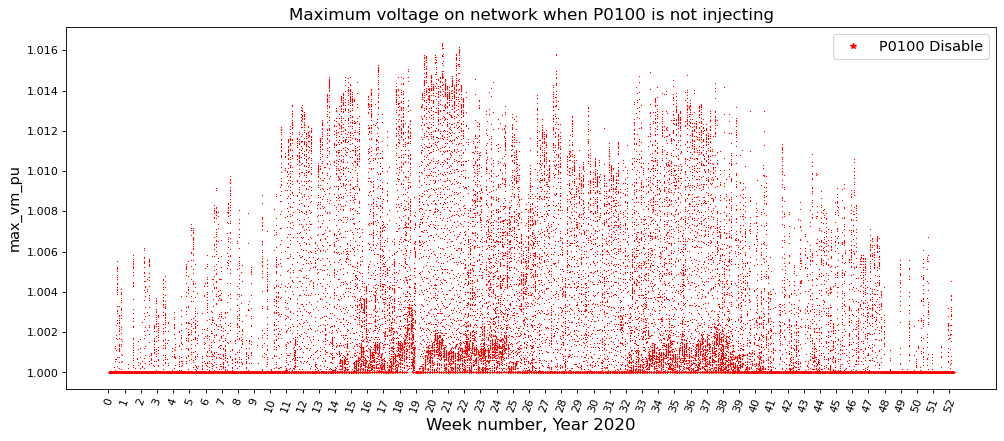

In [33]:
max_vm_pu_df1 = pd.DataFrame(data=list_max_vm_pu1, index=per_index, columns=['max_vm_pu'])
plt.figure(figsize=(15,6), dpi=80)
plt.plot(range(len(max_vm_pu_df1)), max_vm_pu_df1.values,'r*', markersize=0.5, label='P0100 Disable')
nb_per_days = 6*24 # Total number of periods whitin a day
nb_per_week = nb_per_days*7
plt.xticks(range(0,len(max_vm_pu_df1), nb_per_week), labels=range(53), rotation=70);
plt.ylabel('max_vm_pu', fontsize=13)
plt.xlabel('Week number, Year 2020', fontsize=15)
plt.title("Maximum voltage on network when P0100 is not injecting", fontsize=15);
plt.legend(fontsize=13, markerscale=10);
# plt.xlim([0,144*10])

#### Plot both cases i.e. when P0100 is enable and disable

(0.0, 53424.0)

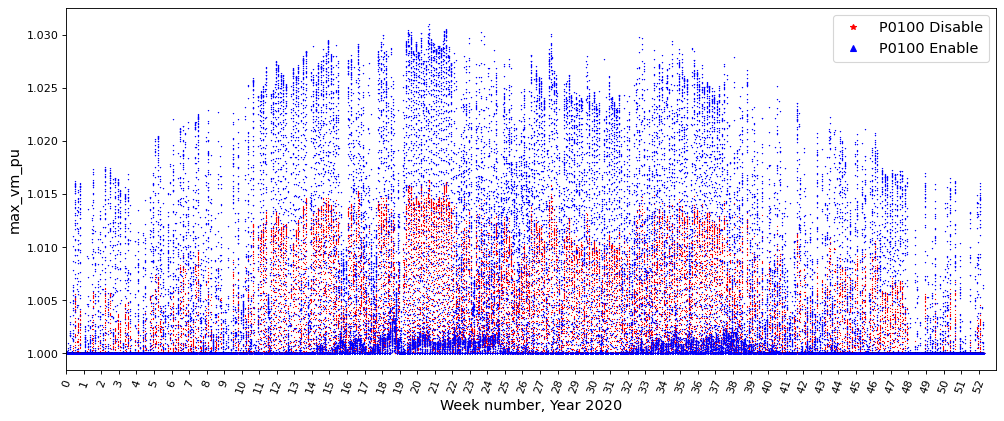

In [34]:
max_vm_pu_df1 = pd.DataFrame(data=list_max_vm_pu1, index=per_index, columns=['max_vm_pu'])
plt.figure(figsize=(15,6), dpi=80)
plt.plot(range(len(max_vm_pu_df1)), max_vm_pu_df1.values,'r*', markersize=0.5, label='P0100 Disable')
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df.values,'b^', markersize=0.5, label='P0100 Enable')
nb_per_days = 6*24 # Total number of periods whitin a day
nb_per_week = nb_per_days*7
plt.xticks(range(0,len(max_vm_pu_df1), nb_per_week), labels=range(52+1),rotation=70);
plt.xlabel('Week number, Year 2020', fontsize=13)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(fontsize=13, markerscale=10)

week_start, week_end = 0, 53
xlim_start, xlim_end = 144*7*week_start, 144*7*week_end
plt.xlim([xlim_start, xlim_end])
# plt.ylim([1,1.020])

## Run optimal power flow 

In [35]:
net_civaux2=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Disable P0100
# net_civaux1.switch.loc[net_civaux1.switch.bus==7, 'closed'] = False 

# Add a controllable line to the static generators
net_civaux2.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux2.sgen['controllable'][net_civaux2.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux2.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux2.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux2.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux2_hv_bus = list(net_civaux1.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

# net_civaux2_hv_bus = net_civaux2_hv_bus[net_civaux1_hv_bus.max_vm_pu.notna()]

pp.runpp(net_civaux2) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux2.res_bus.vm_pu[net_civaux2.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux2_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux2_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [36]:
vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choose 


#### Load data from simultion file

In [37]:
list_max_vm_pu2 = STLaurentDeJourdes_dict['list_max_vm_pu2']
list_sgen_HT = STLaurentDeJourdes_dict['list_sgen_HT']


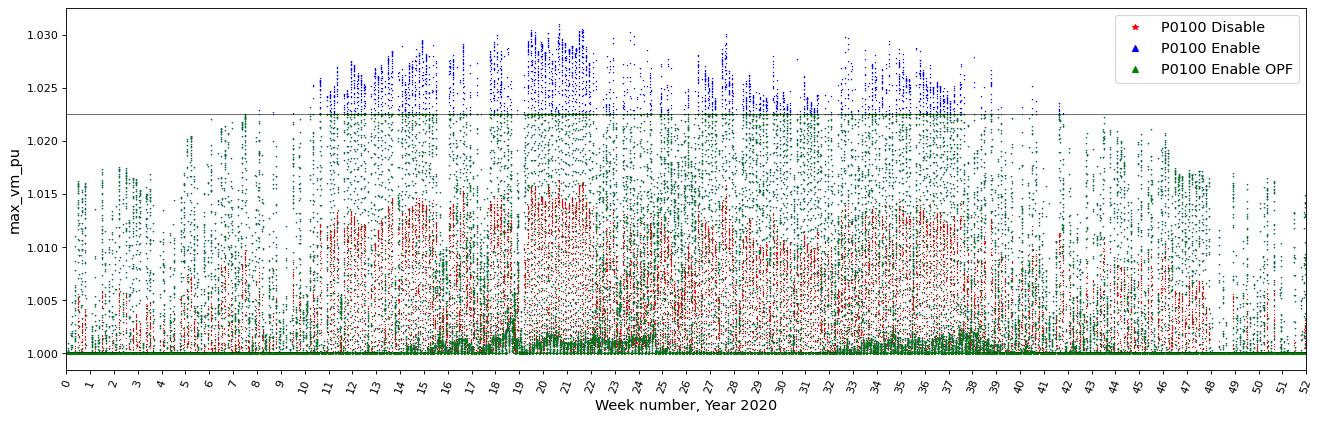

In [38]:
max_vm_pu_df2 = pd.DataFrame(data=list_max_vm_pu2, index=per_index, columns=['max_vm_pu'])
plt.figure(figsize=(20,6), dpi=80)
plt.plot(range(len(max_vm_pu_df1)), max_vm_pu_df1.values,'r*', markersize=0.5, label='P0100 Disable')
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df.values,'b^', markersize=0.5, label='P0100 Enable')
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df2.values,'g^', markersize=0.5, label='P0100 Enable OPF')

nb_per_days = 6*24 # Total number of periods whitin a day
nb_per_week = nb_per_days*7
plt.xticks(range(0,len(max_vm_pu_df1), nb_per_week), labels=range(52+1),rotation=70);
plt.xlabel('Week number, Year 2020', fontsize=13)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(fontsize=13, markerscale=10)

week_start, week_end = 0, 52
xlim_start, xlim_end = 144*7*week_start, 144*7*week_end
plt.xlim([xlim_start, xlim_end])
# plt.ylim([1,1.020])
plt.axhline(vm_mu_max,color='k', lw=0.5)

In [39]:
prod_no_curt_mwh = df_prodHT['P0100'].sum()*Δt  # P0100 energy production when not curtailed
prod_curt_mw = np.array(list_sgen_HT)[:,2]                # P0100 power production after curtailement
prod_curt_mwh = prod_curt_mw.sum(axis=0)*Δt     # P0100 energy production after curtailed
prod_curt_mw_df = pd.DataFrame(data=prod_curt_mw, index=per_index)

# Percentage of power not injected into the grid during the year considered
perc_not_injected_mw = np.round((df_prodHT['P0100']-prod_curt_mw)*100/df_prodHT['P0100'], decimals=2)

# Percentage of energy not injected into the grid during the year considered
perc_not_injected_mwh = np.round((prod_no_curt_mwh-prod_curt_mwh)*100/prod_no_curt_mwh, decimals=2)


prod_curt_mw_df[prod_curt_mw_df<1e-6]=0 # replace lower value (lower than 1wh) by 0


perc_not_injected = pd.DataFrame(np.zeros(len(per_index)),index=per_index)

perc_not_injected[df_prodHT.P0100>0] = (100*(df_prodHT.P0100[df_prodHT.P0100>0] - prod_curt_mw_df[df_prodHT.P0100>0].round(decimals=4).loc[:,0])/
                                        df_prodHT.P0100[df_prodHT.P0100>0]).values.reshape((len(perc_not_injected[df_prodHT.P0100>0]),1))

print(f'P0100 prod,   No curting  : {prod_no_curt_mwh:.2f} MWh')
print(f'P0100 prod, With curting  : {prod_curt_mwh:.2f} MWh')
print(f'Percentage of total \n      energy not injected : {perc_not_injected_mwh} %')



P0100 prod,   No curting  : 5033.34 MWh
P0100 prod, With curting  : 4717.35 MWh
Percentage of total 
      energy not injected : 6.28 %


#### Some other plots

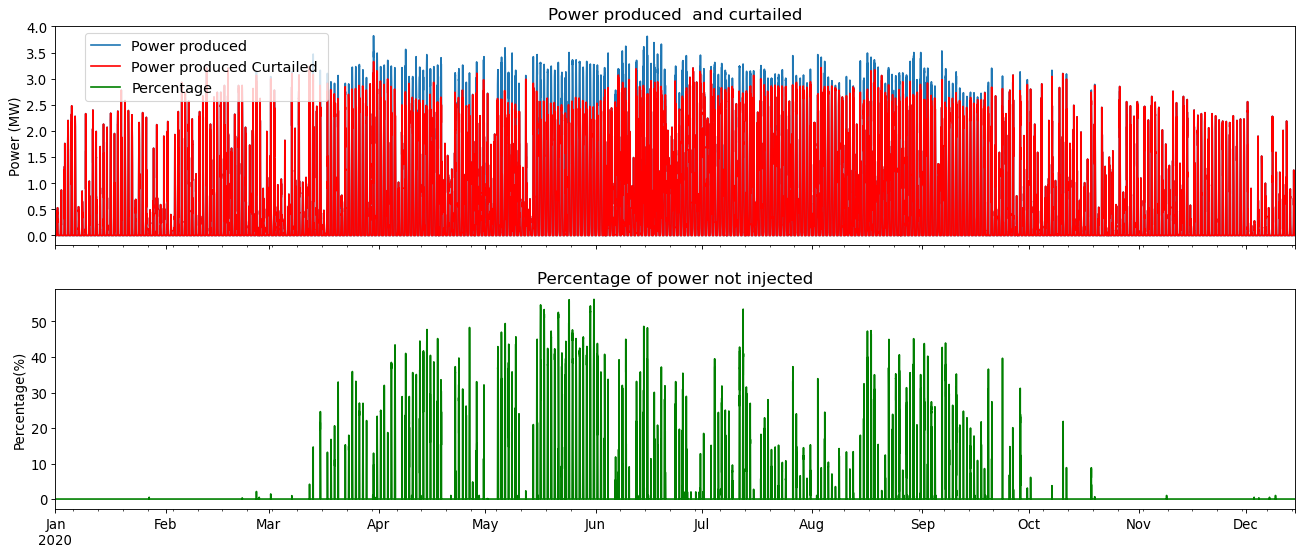

In [40]:
fig, axx = plt.subplots(2, figsize=(20,8), sharex=True, dpi=80)
df_prodHT.P0100.plot(ax=axx[0],legend=False)
prod_curt_mw_df.plot(ax=axx[0], color='red',
                     legend=False,fontsize=12,)
axx[0].set_title('Power produced  and curtailed',fontsize=15)
axx[0].set_ylabel('Power (MW)',fontsize=12)



perc_not_injected.plot(ax=axx[1], color="green", legend=False,
                       xlim=['2020 01 01', '2020 12 15'], fontsize=12,)
axx[1].set_title('Percentage of power not injected', fontsize=15)
axx[1].set_ylabel('Percentage(%)',fontsize=12)

fig.legend(['Power produced','Power produced Curtailed ', 'Percentage'],
          loc='upper right', 
           bbox_to_anchor=(0.3, 0.88), 
           ncol=1, fontsize=13)


# plt.grid(axis='both', which='Both')

#### Some other statistics

In [41]:
perc_not_injected[perc_not_injected<1e-6]=0 # Set to zero all the percentage value lower than (1w)

int_var = (perc_not_injected>0).sum()*100/(df_prodHT.P0100>1e-6).sum()# Actual period of production

# int_var = (perc_not_injected>0).sum()*100/len(perc_not_injected)
print('Percentage of time \n \twhen curtailement occurs :', np.round(int_var[0], decimals=2),'%')

Percentage of time 
 	when curtailement occurs : 11.28 %


#### Plot Stats about the percentage of power not injected into the grid

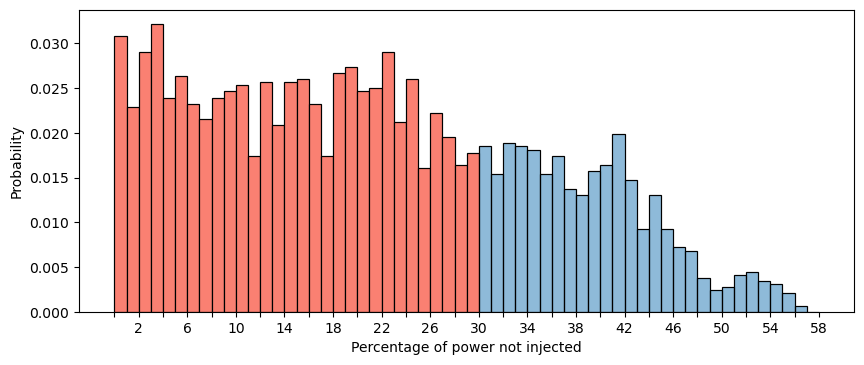

In [42]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=58, binrange=[0,58],
             stat='probability', ax=axx, cumulative= False,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        xticks=range(0,60,2), 
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);
for elm in axx.patches[:30]: elm.set_facecolor('salmon')

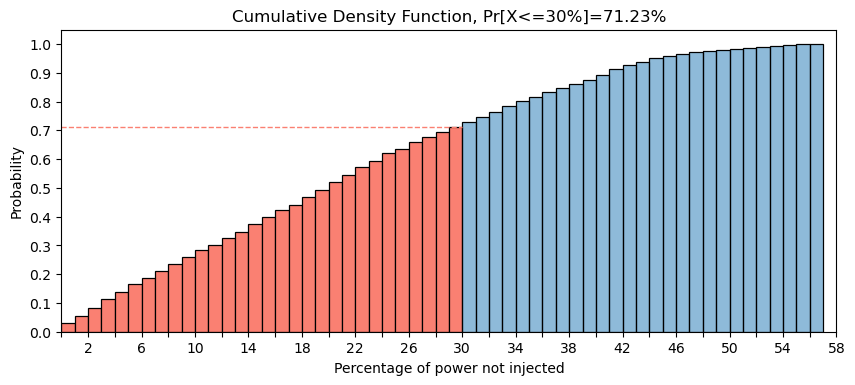

In [43]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=57, binrange=[0,57],
             stat='probability', ax=axx, cumulative=True,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        yticks=np.arange(0,1.1,.1),
        xticks=range(0,60,2),
        xlim=(0,58),
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);

perc_to_consider= 30
for elm in axx.patches[:perc_to_consider]: elm.set_facecolor('salmon')

x_maxx = axx.patches[perc_to_consider].get_x()/58
axx.axhline(axx.patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)
plt.title(f'Cumulative Density Function, Pr[X<={perc_to_consider}%]={axx.patches[perc_to_consider-1].get_height()*100:.2f}%');

#### Elapsed time analysis

In [169]:
df0 = pd.DataFrame([[15,390, 33],[7,165,12]], columns=['PF','OPF', 'Combined'], index=['Serial', 'Parallel'])
df1 = pd.DataFrame([[6,220, .0],[2,84, .0]], columns=['PF Day','OPF Day', ''], index=['Serial', 'Parallel'])
# df2 = pd.DataFrame([[33],[12]], columns=['Combined'], index=['Serial', 'Parallel'])

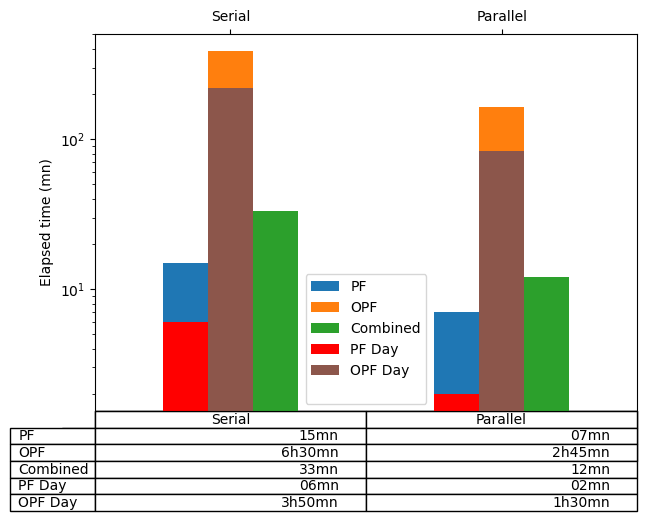

In [200]:
df_fig = pd.concat([df0, df1,], axis=1).T
df_fig['Serial'] = ['15mn', '6h30mn', '33mn', '06mn', '3h50mn', '']
df_fig ['Parallel'] = ['07mn', '2h45mn', '12mn', '02mn', '1h30mn','']


fig, axx = plt.subplots(figsize=(7,5),dpi=100)
df0.plot(kind='bar', logy=True, ax=axx, table=df_fig.loc[['PF','OPF'],:], ylabel = 'Elapsed time (mn)',)
df1.plot(kind='bar', logy=True, ax=axx, color=['red','tab:brown','white'],table =df_fig.iloc[:-1,:] )


axx.xaxis.set_ticks_position('top')
# plt.xticks(,[]);